In [101]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()



## Acquire data

In [2]:
# Read case in CSV file 
case = spark.read.csv("case.csv",sep=",",header=True,inferSchema=True)
# Read dept in CSV file 
dept = spark.read.csv("dept.csv",sep=",",header=True,inferSchema=True)
# Read source in CSV file 
source = spark.read.csv("source.csv",sep=",",header=True,inferSchema=True)
          

In [3]:
# source_id as an int instead of string
source =source.withColumn('source_id', col('source_id').cast('int'))

# use .withColumn to change columns from string to boolean values
dept = dept.withColumn('dept_subject_to_SLA', expr('dept_subject_to_SLA == "YES"'))

# use .withColumn to change columns from string to boolean values
case = case.withColumn('case_closed', expr('case_closed == "YES"'))\
.withColumn('case_late', expr('case_late == "YES"'))

# council_district as a string instead of int
case = case.withColumn('council_district', col('council_district').cast('string'))
# use format_string function to pad zeros for council_district
case = case.withColumn('council_district', format_string('%03d', col('council_district').cast('int')))

# to_timestamp, fmt

fmt = "M/d/yy H:mm"

case = case.withColumn('case_opened_date', to_timestamp('case_opened_date', fmt))\
.withColumn('case_closed_date', to_timestamp('case_closed_date', fmt))\
.withColumn('SLA_due_date', to_timestamp('SLA_due_date', fmt))

# Rename 'SLA_due_date' to 'case_due_date' using .withColumnRenamed
case = case.withColumnRenamed('SLA_due_date', 'case_due_date')
case = case.withColumn('request_address', trim(lower(case.request_address)))

# convert the number of days a case is late to a number of weeks
case = case.withColumn('num_weeks_late', expr('num_days_late/7'))

# create a new column for zipcode:
case = case.withColumn('zipcode', regexp_extract('request_address', r"(\d+$)", 1))


#create three new columns 'case_age', 'days_to_closed', 'case_lifetime'

case = (
    case.withColumn(
        "case_age", datediff(current_timestamp(), "case_opened_date")
    )
    .withColumn(
        "days_to_closed", datediff("case_closed_date", "case_opened_date")
    )
    .withColumn(
        "case_lifetime",
        when(expr("! case_closed"), col("case_age")).otherwise(
            col("days_to_closed")
        ),
    )
)

In [4]:
#join case with dept_divisionb
df = (
    case
    # left join on dept_division
    .join(dept, "dept_division", "left")
    # drop  the columns : dept_division, dept_name  standardized name, as it has much fewer unique values
    .drop(dept.dept_division)
    .drop(dept.dept_name)
    #rename standardized name,  
    .withColumnRenamed("standardized_dept_name", "department")
)

In [5]:
#joint df  with source

(
    case.join(source, "source_id", "left")
    .sort(col("source_username"))
    .show(5, vertical=True)
)

-RECORD 0------------------------------------
 source_id            | jw10936              
 case_id              | 1013787134           
 case_opened_date     | 2017-08-11 07:36:00  
 case_closed_date     | 2017-08-16 17:24:00  
 case_due_date        | 2017-10-16 08:30:00  
 case_late            | false                
 num_days_late        | -60.62914352         
 case_closed          | true                 
 dept_division        | Code Enforcement     
 service_request_type | Overgrown Yard/Trash 
 SLA_days             | 66.03743056          
 case_status          | Closed               
 request_address      | 2522  moss bluff,... 
 council_district     | 009                  
 num_weeks_late       | -8.661306217142856   
 zipcode              | 78232                
 case_age             | 1459                 
 days_to_closed       | 5                    
 case_lifetime        | 5                    
 source_username      | null                 
-RECORD 1-------------------------

In [6]:
df.show(1, vertical= True)

-RECORD 0------------------------------------
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1316                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true      

# Exercises



### Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

### 1. How many different cases are there, by department?

In [78]:
#total the cases by department
df.groupBy('department').agg(count('service_request_type')).show()
#same thing 
#df.groupBy('department').count().show()

+--------------------+---------------------------+
|          department|count(service_request_type)|
+--------------------+---------------------------+
|         Solid Waste|                     279270|
|Animal Care Services|                     116915|
|Trans & Cap Impro...|                      96193|
|  Parks & Recreation|                      19907|
|    Customer Service|                       2849|
|        Metro Health|                       5163|
|        City Council|                         33|
|DSD/Code Enforcement|                     321374|
+--------------------+---------------------------+



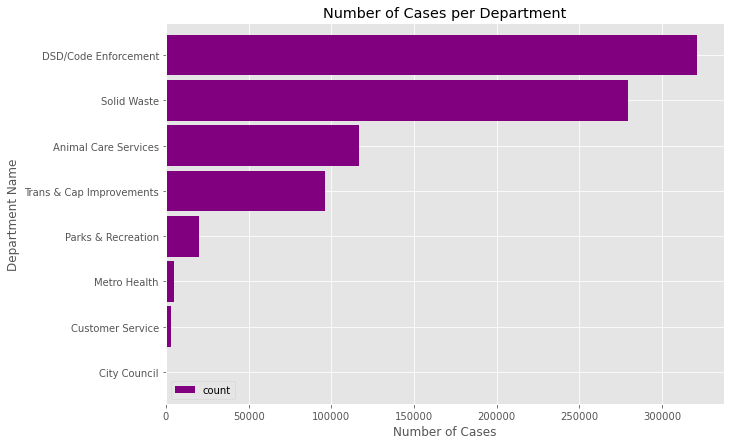

In [79]:
(
    df.groupby('department').count()
    .toPandas()
    .set_index('department')
    .sort_values(by = 'count', ascending = True)
    .plot.barh(color = 'purple', figsize = (10,7), width = .9)
)

plt.title('Number of Cases per Department')
plt.xlabel('Number of Cases')
plt.ylabel('Department Name')
plt.show()

In [80]:
#this gives us the number of cases per service request type per department
df.groupBy('department', 'service_request_type').count().orderBy('department').show()

+--------------------+--------------------+-----+
|          department|service_request_type|count|
+--------------------+--------------------+-----+
|Animal Care Services|Public Nuisance(O...|10715|
|Animal Care Services|     Officer Standby| 3013|
|Animal Care Services|Spay/Neuter Reque...|    1|
|Animal Care Services|City Council Anim...|  365|
|Animal Care Services|Animal Cruelty(Cr...| 3001|
|Animal Care Services|      Animal Neglect|13441|
|Animal Care Services|Animal Permits Re...| 3026|
|Animal Care Services|Aggressive Animal...|24882|
|Animal Care Services|Injured Animal(Cr...| 9633|
|Animal Care Services|Aggressive Animal...| 5266|
|Animal Care Services|Animal Bite(Criti...|  708|
|Animal Care Services|Trapped/Confined ...|11354|
|Animal Care Services|        Stray Animal|26760|
|Animal Care Services|Animal Bite(Non-C...| 4750|
|        City Council|CCO_Request for R...|    2|
|        City Council|Request for Resea...|   31|
|    Customer Service|          Compliment|  461|


In [81]:
#convert to pandas this table
df_pandas= df.groupBy('department', 'service_request_type').count().orderBy('department')\
.toPandas()

In [82]:
df_pandas.shape

(335, 3)

In [83]:
df_pandas.head()

,department,service_request_type,count
0,Animal Care Services,Injured Animal(Critical),9633
1,Animal Care Services,Aggressive Animal(Critical),5266
2,Animal Care Services,Spay/Neuter Request Response,1
3,Animal Care Services,Animal Bite(Critical),708
4,Animal Care Services,Trapped/Confined Animal,11354


In [84]:
#we want how many different case there are per department
df_pandas.groupby(df_pandas.department).count()['count']

department
Animal Care Services         14
City Council                  2
Customer Service              2
DSD/Code Enforcement        122
Metro Health                 14
Parks & Recreation           44
Solid Waste                  56
Trans & Cap Improvements     81
Name: count, dtype: int64

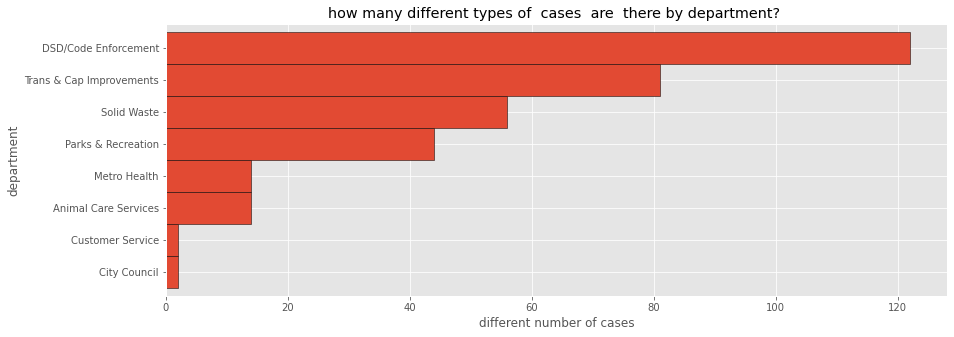

In [85]:
#plot
df_pandas.groupby(df_pandas.department).count()['count'].sort_values(ascending=True)\
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))

plt.xlabel('different number of cases')
plt.title("how many different types of  cases  are  there by department? ")
plt.show()

### 2. Does the percentage of cases that are late vary by department?

In [86]:
#count late cases bt deparment
df.where(df.case_late).groupBy('department').count().show()

+--------------------+-----+
|          department|count|
+--------------------+-----+
|         Solid Waste|32945|
|Animal Care Services|23276|
|Trans & Cap Impro...| 5411|
|  Parks & Recreation| 3797|
|    Customer Service| 2010|
|        Metro Health|  829|
|DSD/Code Enforcement|26235|
+--------------------+-----+



In [87]:
#we need the late cases and non late cases in order to calculate total by department
df.groupby('department').pivot('case_late').count().fillna(0).show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|246325|32945|
|Animal Care Services| 93639|23276|
|Trans & Cap Impro...| 90782| 5411|
|    Customer Service|   839| 2010|
|  Parks & Recreation| 16110| 3797|
|        Metro Health|  4334|  829|
|        City Council|    33|    0|
|DSD/Code Enforcement|295139|26235|
+--------------------+------+-----+



In [88]:
#create a new table
late_cases = df.groupby('department').pivot('case_late').count().fillna(0)

In [89]:
#add a column with total by department
late_cases= late_cases.withColumn('total', ( col('true') + col('false')) )

In [90]:
late_cases.show()

+--------------------+------+-----+------+
|          department| false| true| total|
+--------------------+------+-----+------+
|         Solid Waste|246325|32945|279270|
|Animal Care Services| 93639|23276|116915|
|Trans & Cap Impro...| 90782| 5411| 96193|
|    Customer Service|   839| 2010|  2849|
|  Parks & Recreation| 16110| 3797| 19907|
|        Metro Health|  4334|  829|  5163|
|        City Council|    33|    0|    33|
|DSD/Code Enforcement|295139|26235|321374|
+--------------------+------+-----+------+



In [91]:
#conver to pandas
df_pandas = late_cases.toPandas().set_index('department')

In [94]:
df_pandas ['percentage'] =(df_pandas['false'] / df_pandas['total'] *100)

In [95]:
df_pandas

,false,true,total,percentage
department,,,,
Solid Waste,246325,32945,279270,88.203173
Animal Care Services,93639,23276,116915,80.091519
Trans & Cap Improvements,90782,5411,96193,94.374851
Customer Service,839,2010,2849,29.448929
Parks & Recreation,16110,3797,19907,80.926307
Metro Health,4334,829,5163,83.943444
City Council,33,0,33,100.000000
DSD/Code Enforcement,295139,26235,321374,91.836614


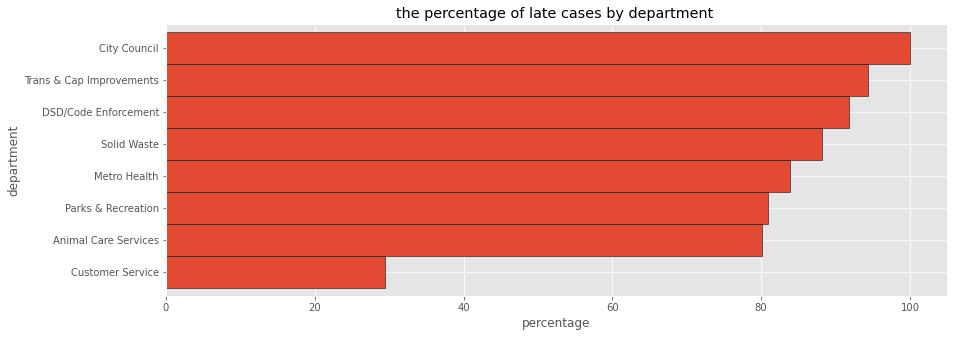

In [97]:
df_pandas.percentage.sort_values().plot.barh(width=1, edgecolor="black", figsize=(14, 5))
plt.xlabel('percentage')
plt.title("the percentage of late cases by department ")
plt.show()

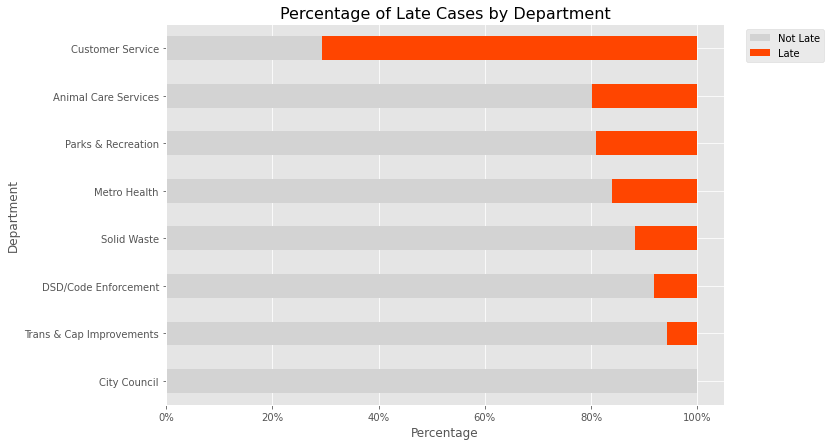

In [110]:
#other way to do it
(df_pandas.apply(lambda row: row / row['total'], axis = 1)
    .drop(columns = ['total', 'percentage'])
    .sort_values(by = 'true')
    .plot.barh(stacked = True, figsize = (10,7), color = ['lightgrey', 'orangered'])
)
plt.legend(labels = ['Not Late', 'Late'], bbox_to_anchor = ((1.03, 1)))
plt.title('Percentage of Late Cases by Department', fontsize = 16)
plt.xlabel('Percentage')
plt.ylabel('Department')
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))

plt.show()

### 3. On average, how late are the late cases by department?

In [112]:
df.where(df.case_late).groupBy('department').mean('num_days_late').sort(desc('avg(num_days_late)')).show()

+--------------------+------------------+
|          department|avg(num_days_late)|
+--------------------+------------------+
|    Customer Service| 87.68385942150395|
|DSD/Code Enforcement|49.384287053588935|
|Animal Care Services|23.458633245820135|
|  Parks & Recreation|22.348910457867508|
|Trans & Cap Impro...| 10.60306468031694|
|         Solid Waste| 7.186821906120906|
|        Metro Health| 6.543813315547647|
+--------------------+------------------+



In [23]:
df_pandas =df.where(df.case_late).groupBy('department').mean('num_days_late').toPandas().set_index('department')

In [24]:
df_pandas

,avg(num_days_late)
department,
Solid Waste,7.186822
Animal Care Services,23.458633
Trans & Cap Improvements,10.603065
Parks & Recreation,22.348910
Customer Service,87.683859
Metro Health,6.543813
DSD/Code Enforcement,49.384287


Text(0.5, 0, 'Number of days')

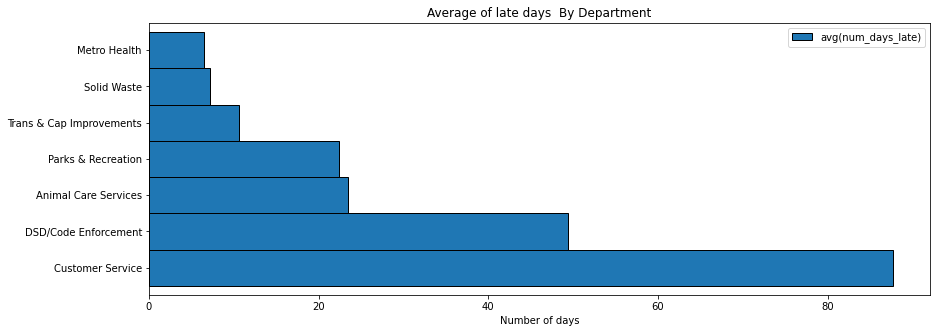

In [25]:
df_pandas.sort_values(by='avg(num_days_late)',  ascending= False)\
.plot.barh(width=1, edgecolor="black", figsize=(14, 5))

plt.title("Average of late days  By Department")
plt.ylabel("")
plt.xlabel("Number of days")

### 4. What is the service type that is the most late? Just for Parks & Rec?

In [26]:
df.where((df.department == "Parks & Recreation") & (df.case_late)).show(1, vertical= True)

-RECORD 0------------------------------------
 dept_division        | Tree Crew            
 case_id              | 1014127895           
 case_opened_date     | 2018-01-02 07:23:00  
 case_closed_date     | 2018-01-17 14:35:00  
 case_due_date        | 2018-01-17 08:30:00  
 case_late            | true                 
 num_days_late        | 0.254108796          
 case_closed          | true                 
 service_request_type | Tree Removal         
 SLA_days             | 15.04645833          
 case_status          | Closed               
 source_id            | svcCRMSS             
 request_address      | 1315  san pedro a... 
 council_district     | 001                  
 num_weeks_late       | 0.036301256571428575 
 zipcode              | 78212                
 case_age             | 1315                 
 days_to_closed       | 15                   
 case_lifetime        | 15                   
 department           | Parks & Recreation   
 dept_subject_to_SLA  | true      

In [27]:
df.where((df.department == "Parks & Recreation") & (df.case_late))\
.groupBy('service_request_type').mean('num_days_late').orderBy(desc('avg(num_days_late)')).show(50)

+--------------------+------------------+
|service_request_type|avg(num_days_late)|
+--------------------+------------------+
|Amenity Park Impr...|    76.87018194568|
|Major Park Improv...| 75.79450367282352|
|Reservation Assis...|       66.03116319|
|Park Building Mai...| 59.36746980269565|
| Sportfield Lighting|51.480049793645534|
|          Electrical|  42.9519716583451|
|        Tree Removal| 40.28404224560714|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253489|
|Tree Trimming/Mai...|30.702768979017538|
|General Building ...|28.192905974561906|
|             Masonry|27.989420392890622|
|            Painting|25.404551756282608|
|    Sign Maintenance|22.281778663588234|
|   Fence/Gate Repair|20.366796601056606|
|Small Equipment R...|      19.644149305|
|               Pools|19.489430630709677|
|            Plumbing|18.621826175298462|
|Plumbing/Drinking...| 18.18076193409091|
|          Irrigation| 17.58814428

In [28]:
df_pandas = df.where((df.department == "Parks & Recreation") & (df.case_late))\
.groupBy('service_request_type').mean('num_days_late').orderBy(desc('avg(num_days_late)'))\
.toPandas().set_index('service_request_type')

In [29]:
plt.style.use("ggplot")

Text(0.5, 0, 'Number of days')

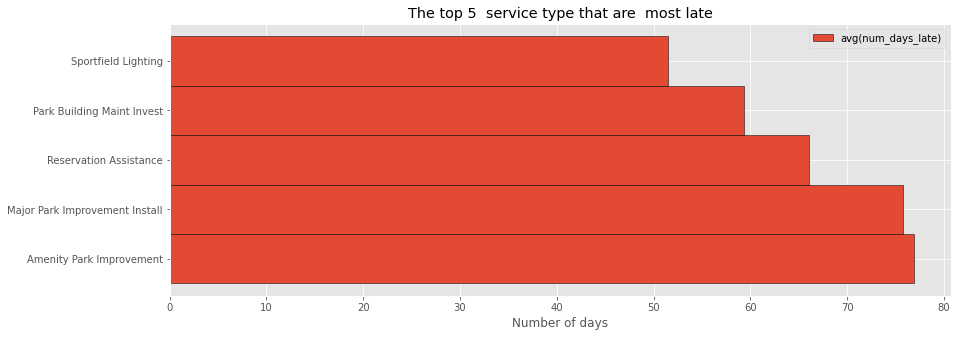

In [30]:
df_pandas.head(5).plot.barh(width=1, edgecolor="black", figsize=(14, 5))


plt.title("The top 5  service type that are  most late")
plt.ylabel("")
plt.xlabel("Number of days")

Text(0.5, 0, 'Number of days')

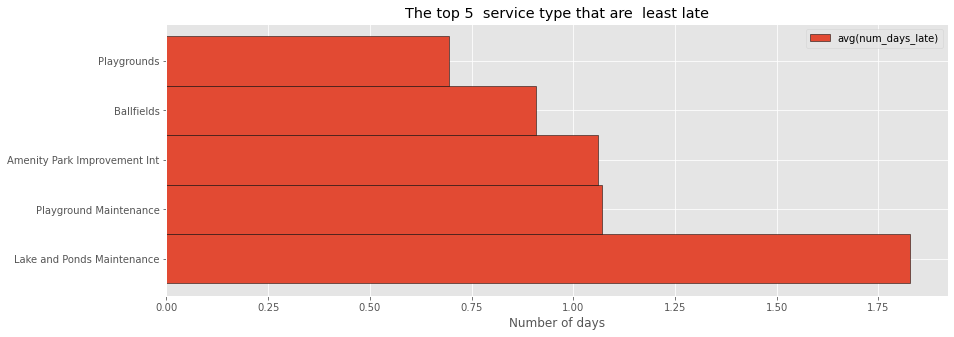

In [31]:
df_pandas.tail(5).plot.barh(width=1, edgecolor="black", figsize=(14, 5))


plt.title("The top 5  service type that are  least late")
plt.ylabel("")
plt.xlabel("Number of days")

### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [114]:
df.where(df.department == "DSD/Code Enforcement").groupBy('service_request_type')\
.count().sort(desc('count')).show(20)

+--------------------+-----+
|service_request_type|count|
+--------------------+-----+
|Overgrown Yard/Trash|65895|
|        Bandit Signs|32910|
|Front Or Side Yar...|28794|
|Junk Vehicle On P...|21473|
|Alley-Way Mainten...|20214|
|Right Of Way/Side...|17699|
|Vacant Lot/Overgr...| 9329|
|Minimum Housing-O...| 8543|
|Graffiti: Private...| 8525|
|Dang. Premises/CL...| 8004|
|Minimum Housing-T...| 7984|
|"Vacant Lot-Priva...| 7875|
|    Brush Violations| 7475|
|    Permits Building| 6880|
|Vacant House Over...| 6109|
|  Graffiti: Building| 4572|
|Graffiti Public P...| 4104|
|Low Hanging Limbs...| 4052|
|CPS Energy Wood P...| 3501|
|Zoning Business i...| 2716|
+--------------------+-----+
only showing top 20 rows



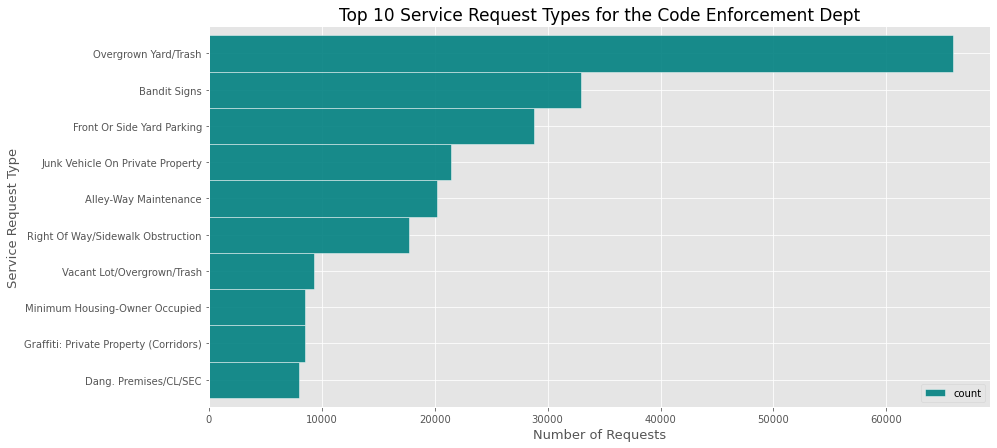

In [125]:
(
df.where(df.department == "DSD/Code Enforcement").groupBy('service_request_type')
.count().sort(desc('count')).toPandas()
.set_index('service_request_type')
.head(10)
.sort_values(by = 'count', ascending = True)
.plot.barh(figsize = (14,7), color = 'teal', width = 1, ec = 'white', alpha = .9)
)
plt.title('Top 10 Service Request Types for the Code Enforcement Dept', fontsize = 17)
plt.xlabel('Number of Requests', fontsize = 13)
plt.ylabel('Service Request Type', fontsize = 13)
plt.show()

In [131]:
#this gives us the number of cases per service request type per department
df.groupBy('department', 'service_request_type').count().orderBy('department',desc('count')).show()

+--------------------+--------------------+-----+
|          department|service_request_type|count|
+--------------------+--------------------+-----+
|Animal Care Services|        Stray Animal|26760|
|Animal Care Services|Aggressive Animal...|24882|
|Animal Care Services|      Animal Neglect|13441|
|Animal Care Services|Trapped/Confined ...|11354|
|Animal Care Services|Public Nuisance(O...|10715|
|Animal Care Services|Injured Animal(Cr...| 9633|
|Animal Care Services|Aggressive Animal...| 5266|
|Animal Care Services|Animal Bite(Non-C...| 4750|
|Animal Care Services|Animal Permits Re...| 3026|
|Animal Care Services|     Officer Standby| 3013|
|Animal Care Services|Animal Cruelty(Cr...| 3001|
|Animal Care Services|Animal Bite(Criti...|  708|
|Animal Care Services|City Council Anim...|  365|
|Animal Care Services|Spay/Neuter Reque...|    1|
|        City Council|Request for Resea...|   31|
|        City Council|CCO_Request for R...|    2|
|    Customer Service|           Complaint| 2388|


In [132]:
df_pandas = df.groupBy('department', 'service_request_type').count().orderBy('department',desc('count'))\
.toPandas()

In [133]:
df_pandas.head()

,department,service_request_type,count
0,Animal Care Services,Stray Animal,26760
1,Animal Care Services,Aggressive Animal(Non-Critical),24882
2,Animal Care Services,Animal Neglect,13441
3,Animal Care Services,Trapped/Confined Animal,11354
4,Animal Care Services,Public Nuisance(Own Animal),10715


In [134]:
df_pandas.groupby(['department']).head(1)

,department,service_request_type,count
0,Animal Care Services,Stray Animal,26760
14,City Council,Request for Research/Information,31
16,Customer Service,Complaint,2388
18,DSD/Code Enforcement,Overgrown Yard/Trash,65895
140,Metro Health,License Renewal Invoice,1349
154,Parks & Recreation,Carpentry,1944
198,Solid Waste,No Pickup,86855
254,Trans & Cap Improvements,Pot Hole Repair,20616


Text(0.5, 0, 'Number of Cases')

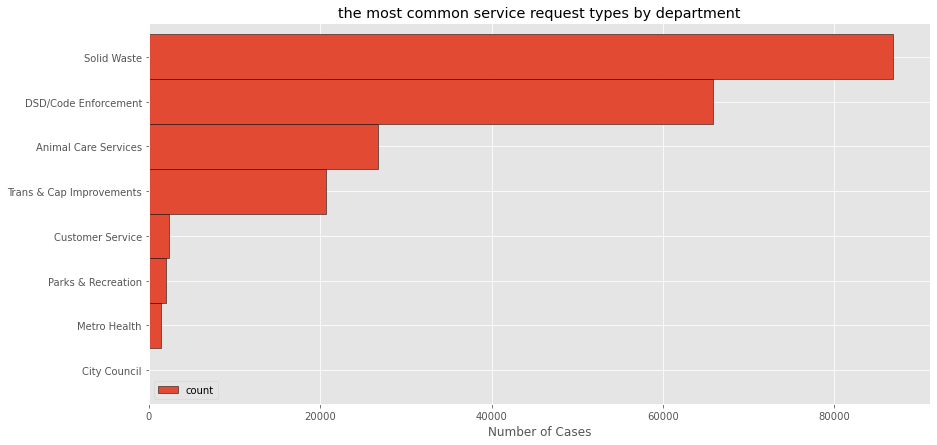

In [141]:
df_pandas.groupby(['department']).head(1).set_index('department').sort_values(by = 'count')\
.plot.barh(width=1, edgecolor="black", figsize=(14, 7))


plt.title("the most common service request types by department")
plt.ylabel("")
plt.xlabel("Number of Cases")

<AxesSubplot:xlabel='service_request_type'>

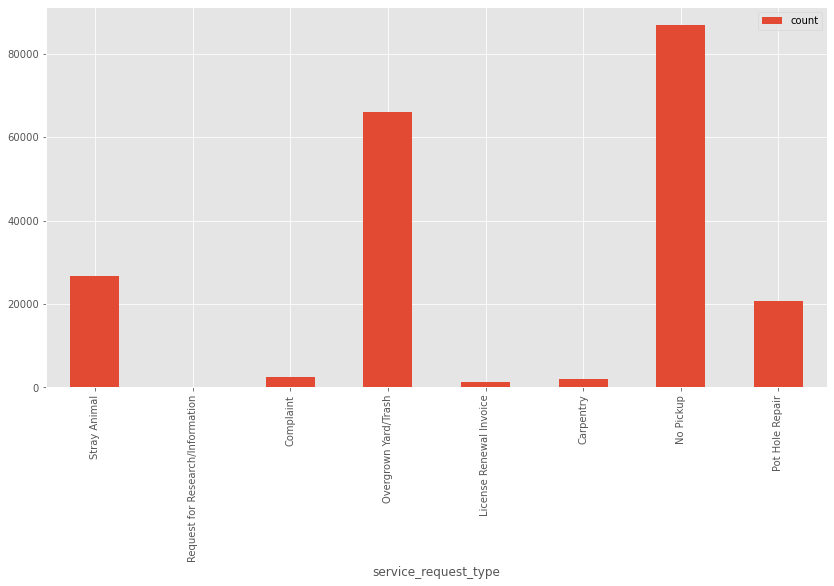

In [143]:
df_pandas.groupby(['department']).head(1).set_index('department')\
.plot.bar(x= 'service_request_type', y = 'count', figsize = (14,7))

In [144]:
import seaborn as sns

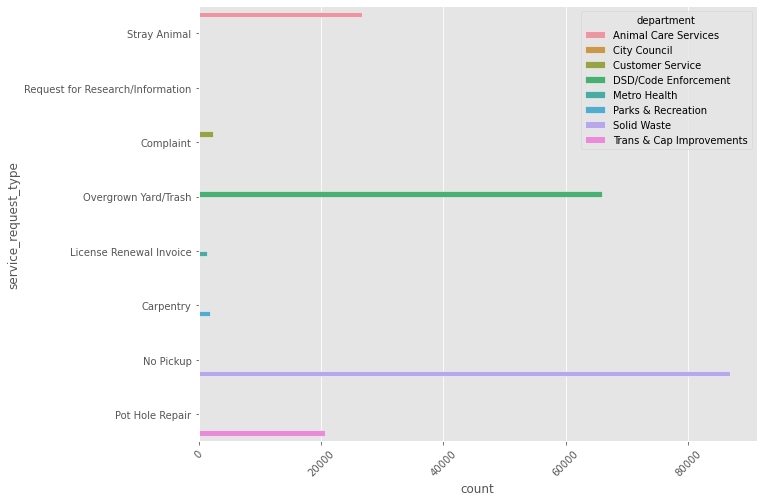

In [151]:
plt.figure(figsize=(10,8) )
sns.barplot(x= 'count', y = 'service_request_type',
            data = df_pandas.groupby(['department']).head(1), hue = 'department',
            orient = 'h', ec = 'white', errwidth= 10.0)
plt.xticks(rotation=45)
#plt.legend(bbox_to_anchor= (1.03,1))

plt.show()

In [41]:
df_pandas.groupby(['department']).head(1)

,department,service_request_type,count
0,Animal Care Services,Stray Animal,26760
14,City Council,Request for Research/Information,31
16,Customer Service,Complaint,2388
18,DSD/Code Enforcement,Overgrown Yard/Trash,65895
140,Metro Health,License Renewal Invoice,1349
154,Parks & Recreation,Carpentry,1944
198,Solid Waste,No Pickup,86855
254,Trans & Cap Improvements,Pot Hole Repair,20616


### 6. Does whether or not its a weekend matter for when a case is opened/closed?

In [157]:
df.show(1,vertical=True)

-RECORD 0------------------------------------
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1316                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true      

**opened cases**

In [162]:
df.groupBy('case_opened_date' ).count().na.drop().sort('case_opened_date').show()

+-------------------+-----+
|   case_opened_date|count|
+-------------------+-----+
|2017-01-01 03:22:00|    4|
|2017-01-01 03:23:00|    2|
|2017-01-01 04:11:00|    1|
|2017-01-01 04:46:00|    1|
|2017-01-01 06:26:00|    1|
|2017-01-01 08:02:00|    1|
|2017-01-01 08:10:00|    1|
|2017-01-01 08:20:00|    1|
|2017-01-01 08:24:00|    1|
|2017-01-01 08:37:00|    1|
|2017-01-01 08:39:00|    1|
|2017-01-01 08:56:00|    1|
|2017-01-01 09:02:00|    1|
|2017-01-01 09:03:00|    1|
|2017-01-01 09:16:00|    1|
|2017-01-01 09:31:00|    1|
|2017-01-01 09:34:00|    1|
|2017-01-01 09:55:00|    1|
|2017-01-01 10:03:00|    1|
|2017-01-01 10:04:00|    1|
+-------------------+-----+
only showing top 20 rows



In [167]:
#create a pandas dt
df_open = df.groupBy('case_opened_date' ).count().na.drop().sort('case_opened_date').toPandas()

In [168]:
df_open.head()

,case_opened_date,count
0,2017-01-01 03:22:00,4
1,2017-01-01 03:23:00,2
2,2017-01-01 04:11:00,1
3,2017-01-01 04:46:00,1
4,2017-01-01 06:26:00,1


In [170]:
#getting the name of the day
df_open['day']= df_open.case_opened_date.dt.day_name()

In [171]:
df_open.head()

,case_opened_date,count,day
0,2017-01-01 03:22:00,4,Sunday
1,2017-01-01 03:23:00,2,Sunday
2,2017-01-01 04:11:00,1,Sunday
3,2017-01-01 04:46:00,1,Sunday
4,2017-01-01 06:26:00,1,Sunday


In [178]:
#all the observatiuon for Sunday
len(df_open[df_open.day == "Sunday"])

23129

In [182]:
#all cases on Sunday
df_open[df_open.day == "Sunday"].sum()

count                                                28765
day      SundaySundaySundaySundaySundaySundaySundaySund...
dtype: object

In [189]:
#cases by each day
df_open.groupby('day').sum().sort_values(by = 'count')

,count
day,
Sunday,28765
Saturday,53678
Friday,143596
Wednesday,147213
Monday,153104
Thursday,153724
Tuesday,161624


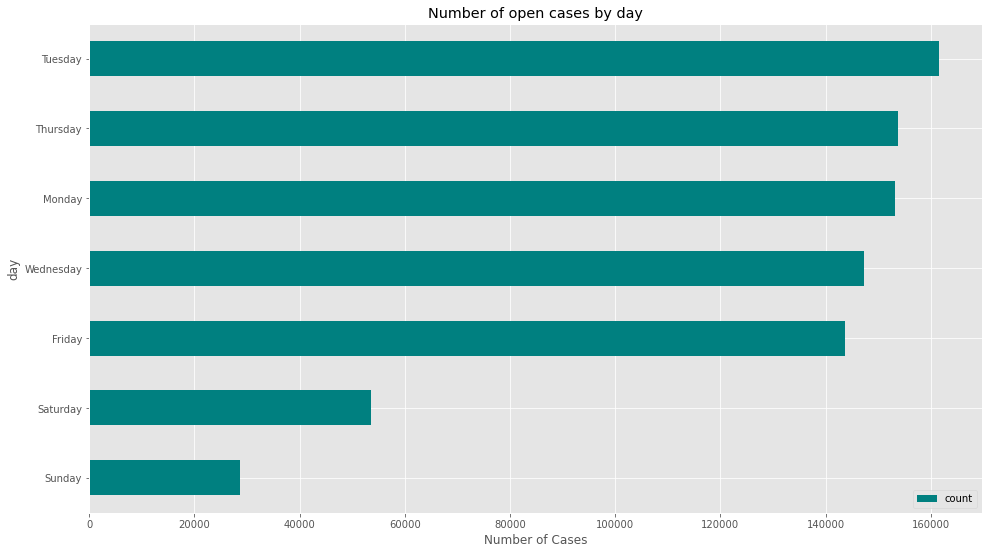

In [198]:
df_open.groupby('day').sum().sort_values(by = 'count')\
.plot.barh(figsize=(16,9), color = "teal")
plt.title("Number of open cases by day")
plt.xlabel("Number of Cases")
plt.show()

In [ ]:
#other way to do it

In [47]:
df.groupBy('case_opened_day').count().sort(desc('count')).show()

+---------------+------+
|case_opened_day| count|
+---------------+------+
|              3|161624|
|              5|153724|
|              2|153104|
|              4|147213|
|              6|143596|
|              7| 53678|
|              1| 28765|
+---------------+------+



In [48]:
df_open = df.groupBy('case_opened_day').count().sort(desc('count')).toPandas().set_index('case_opened_day')

In [50]:
df_open

,count
case_opened_day,
3,161624
5,153724
2,153104
4,147213
6,143596
7,53678
1,28765


<AxesSubplot:xlabel='case_opened_day'>

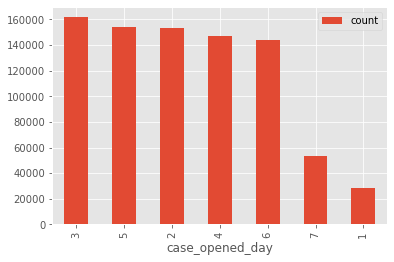

In [51]:
df_open.plot.bar()

**closed cases**

In [199]:
#create a pandas dt
df_closed = df.groupBy('case_closed_date' ).count().na.drop().sort('case_closed_date').toPandas()

In [201]:
df_closed.head()

,case_closed_date,count
0,2017-01-01 06:03:00,1
1,2017-01-01 06:04:00,2
2,2017-01-01 09:10:00,1
3,2017-01-01 09:27:00,1
4,2017-01-01 09:32:00,1


In [203]:
#getting the name of the day
df_closed['day']= df_closed.case_closed_date.dt.day_name()

In [204]:
df_closed.head()

,case_closed_date,count,day
0,2017-01-01 06:03:00,1,Sunday
1,2017-01-01 06:04:00,2,Sunday
2,2017-01-01 09:10:00,1,Sunday
3,2017-01-01 09:27:00,1,Sunday
4,2017-01-01 09:32:00,1,Sunday


In [205]:
df_closed.groupby('day').sum().sort_values(by = 'count')

,count
day,
Sunday,26867
Saturday,61160
Friday,129142
Monday,135069
Thursday,145725
Tuesday,154916
Wednesday,170715


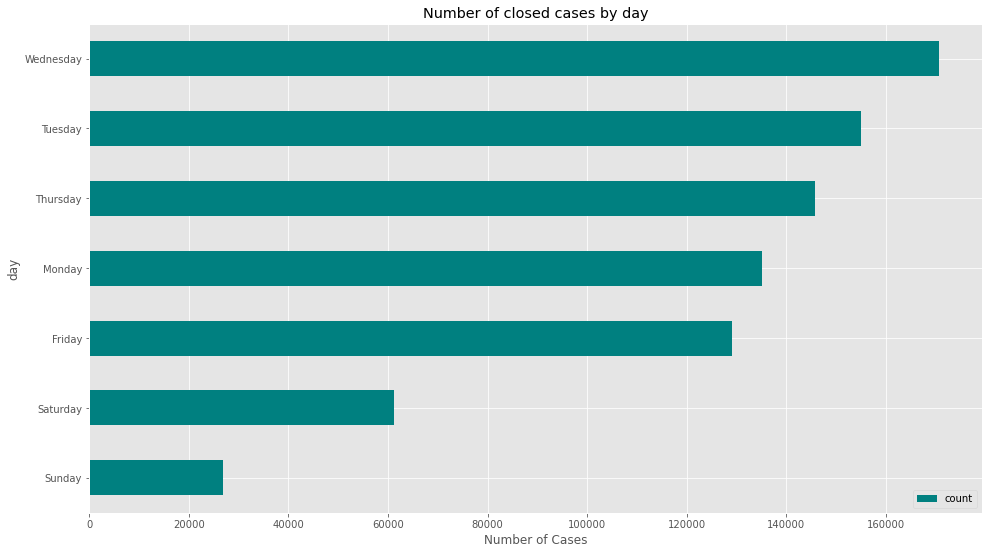

In [206]:
df_closed.groupby('day').sum().sort_values(by = 'count')\
.plot.barh(figsize=(16,9), color = "teal")
plt.title("Number of closed cases by day")
plt.xlabel("Number of Cases")
plt.show()

In [ ]:
#other way to do it

In [52]:
df.groupBy('case_closed_day').count().na.drop().sort(desc('count')).show()

+---------------+------+
|case_closed_day| count|
+---------------+------+
|              4|170715|
|              3|154916|
|              5|145725|
|              2|135069|
|              6|129142|
|              7| 61160|
|              1| 26867|
+---------------+------+



In [53]:
df_closed = df.groupBy('case_closed_day').count().na.drop().sort(desc('count')).toPandas()\
.set_index('case_closed_day')

<AxesSubplot:xlabel='case_closed_day'>

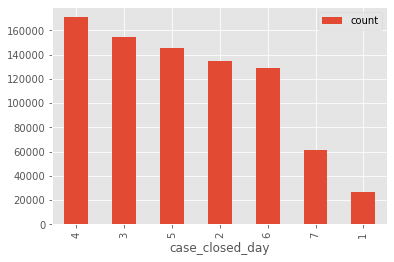

In [54]:
df_closed.plot.bar()

### 7. On average, how many cases are opened a day for the Customer Service department?

In [280]:
#opened cases for customer service
(
df.where(df.department == 'Customer Service')
.groupBy(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date")).count().na.drop().sort('case_opened_date')  
.show()
)

+----------------+-----+
|case_opened_date|count|
+----------------+-----+
|      2017-01-02|    3|
|      2017-01-03|    6|
|      2017-01-04|    2|
|      2017-01-05|    5|
|      2017-01-06|    3|
|      2017-01-07|    2|
|      2017-01-09|    2|
|      2017-01-10|    5|
|      2017-01-11|    3|
|      2017-01-12|    4|
|      2017-01-13|    3|
|      2017-01-14|    2|
|      2017-01-16|    1|
|      2017-01-17|    6|
|      2017-01-18|    6|
|      2017-01-19|    7|
|      2017-01-20|    4|
|      2017-01-21|    3|
|      2017-01-23|    4|
|      2017-01-24|    5|
+----------------+-----+
only showing top 20 rows



In [286]:
# the table above conver to pandas df
cs_df =(df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count().na.drop().sort('case_opened_date')
    .toPandas())

In [287]:
cs_df.head()

,case_opened_date,count
0,2017-01-02,3
1,2017-01-03,6
2,2017-01-04,2
3,2017-01-05,5
4,2017-01-06,3


In [289]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   case_opened_date  512 non-null    object
 1   count             512 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.1+ KB


In [296]:
# Converting to DateTime Type
cs_df['case_opened_date'] = pd.to_datetime(cs_df.case_opened_date)

In [297]:
#create a new column for day
cs_df['day']= cs_df.case_opened_date.dt.day_name()

In [298]:
cs_df['case_opened_date_simple'] = cs_df.case_opened_date.dt.date

In [299]:
cs_df.head()

,case_opened_date,count,day,case_opened_date_simple
0,2017-01-02,3,Monday,2017-01-02
1,2017-01-03,6,Tuesday,2017-01-03
2,2017-01-04,2,Wednesday,2017-01-04
3,2017-01-05,5,Thursday,2017-01-05
4,2017-01-06,3,Friday,2017-01-06


In [300]:
#numer of cases monday
cs_df[cs_df.day == 'Monday'].sum()[0]

444

In [301]:
cs_df[cs_df.day == 'Monday'].mean()

count    5.481481
dtype: float64

In [302]:
cs_df.groupby('day').mean()

,count
day,
Friday,6.578313
Monday,5.481481
Saturday,2.400000
Sunday,1.161290
Thursday,6.829268
Tuesday,7.590361
Wednesday,5.670732


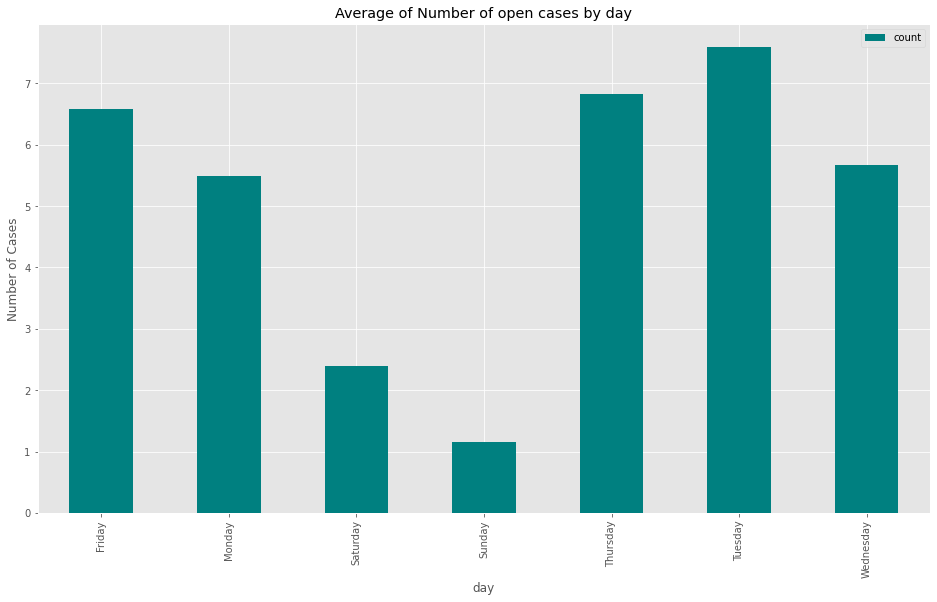

In [303]:
cs_df.groupby('day').mean().plot.bar(figsize=(16,9), color = "teal")
plt.title("Average of Number of open cases by day")
plt.ylabel("Number of Cases")
plt.show()

In [304]:
cs_df.groupby('day').sum()

,count
day,
Friday,546
Monday,444
Saturday,168
Sunday,36
Thursday,560
Tuesday,630
Wednesday,465


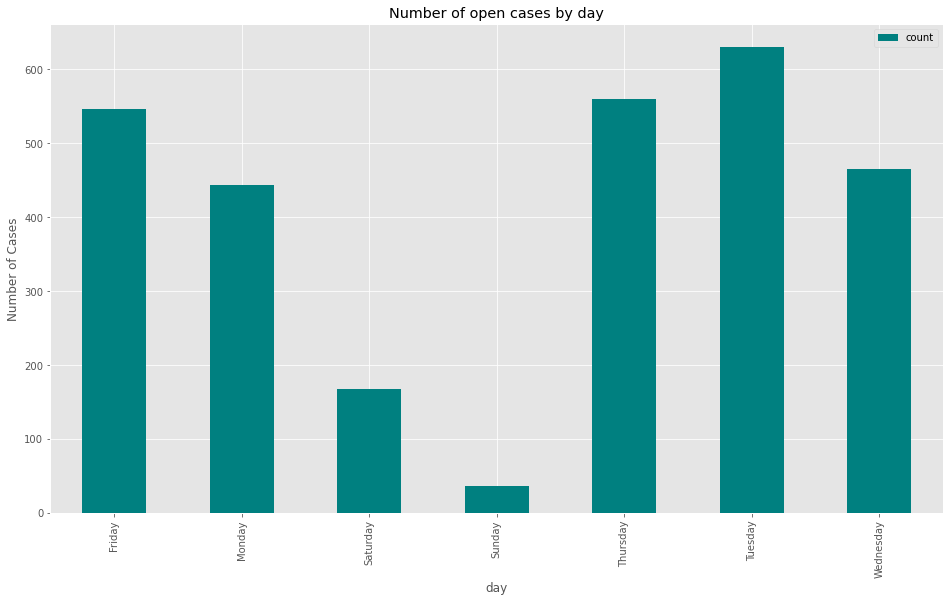

In [305]:
cs_df.groupby('day').sum().plot.bar(figsize=(16,9), color = "teal")
plt.title("Number of open cases by day")
plt.ylabel("Number of Cases")
plt.show()

In [ ]:
#other solutions


In [274]:
def plot_cases(df):
    s = df["count"]
    avg = s.mean()
    s.value_counts().sort_index().plot.bar()
    plt.text(
        8, 50, f"Average Cases Opened Per Day:\n{avg:.2f}", ha="left", size=14
    )
    plt.xlabel("# of cases opened")
    plt.ylabel("# of days with that many cases opened")
    plt.xticks(rotation=0)

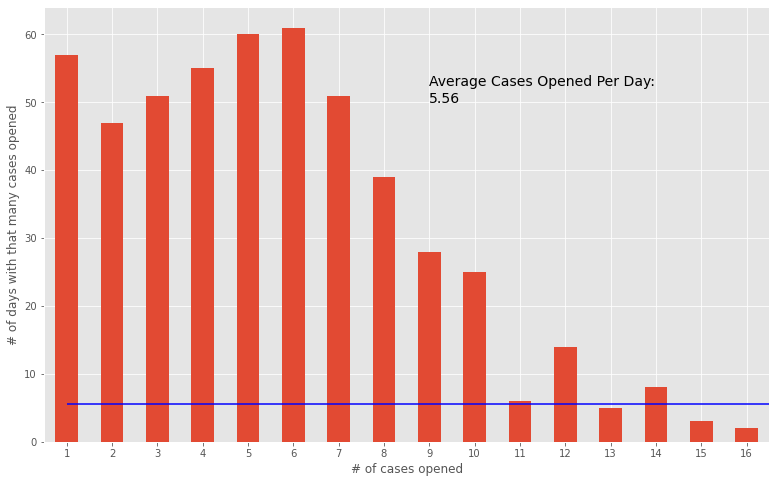

In [316]:
plt.figure(figsize=(13,8))
cs_df["count"].value_counts().sort_index().plot.bar()
plt.text( 8, 50, f"Average Cases Opened Per Day:\n{cs_df['count'].mean():.2f}", ha="left", size=14)
plt.xlabel("# of cases opened")
plt.ylabel("# of days with that many cases opened")
plt.hlines(y =cs_df['count'].mean(), xmin = 0 , xmax= 16, color = 'blue')
plt.xticks(rotation=0)
plt.show()

### 8. Does the number of service requests for the solid waste department vary by day of the week?

In [242]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 dept_division        | Field Operations     
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  el paso st,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 1316                 
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true      

In [250]:
#group by day in a simple form
df.where(df.department == "Solid Waste")\
.groupBy(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"))\
.count().sort('count').show()

+----------------+-----+
|case_opened_date|count|
+----------------+-----+
|      2017-12-25|   19|
|      2018-01-01|   21|
|      2017-11-23|   22|
|      2017-04-16|   43|
|      2017-01-01|   43|
|      2017-12-31|   45|
|      2017-12-24|   45|
|      2017-12-17|   45|
|      2017-08-26|   54|
|      2018-04-01|   60|
|      2017-07-16|   61|
|      2017-11-12|   62|
|      2017-05-21|   64|
|      2017-01-15|   64|
|      2018-02-11|   65|
|      2018-01-14|   66|
|      2017-08-20|   67|
|      2017-10-01|   67|
|      2017-10-29|   67|
|      2018-06-03|   68|
+----------------+-----+
only showing top 20 rows



In [256]:
#create. pandas table
df_pandas = df.where(df.department == "Solid Waste")\
.groupBy(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"))\
.count().sort("case_opened_date").toPandas()

In [257]:
df_pandas.head()

,case_opened_date,count
0,2017-01-01,43
1,2017-01-02,722
2,2017-01-03,771
3,2017-01-04,545
4,2017-01-05,586


In [260]:
#opened date has not a datetime format
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   case_opened_date  585 non-null    object
 1   count             585 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.3+ KB


In [262]:
# Converting to DateTime Type
df_pandas['case_opened_date'] = pd.to_datetime(df_pandas.case_opened_date)

In [263]:
#create new column 
df_pandas['day'] = df_pandas.case_opened_date.dt.day_name()

In [264]:
df_pandas.head()

,case_opened_date,count,day
0,2017-01-01,43,Sunday
1,2017-01-02,722,Monday
2,2017-01-03,771,Tuesday
3,2017-01-04,545,Wednesday
4,2017-01-05,586,Thursday


In [267]:
df_pandas.groupby('day').sum()

,count
day,
Friday,51203
Monday,58085
Saturday,15312
Sunday,6885
Thursday,47718
Tuesday,58120
Wednesday,41947


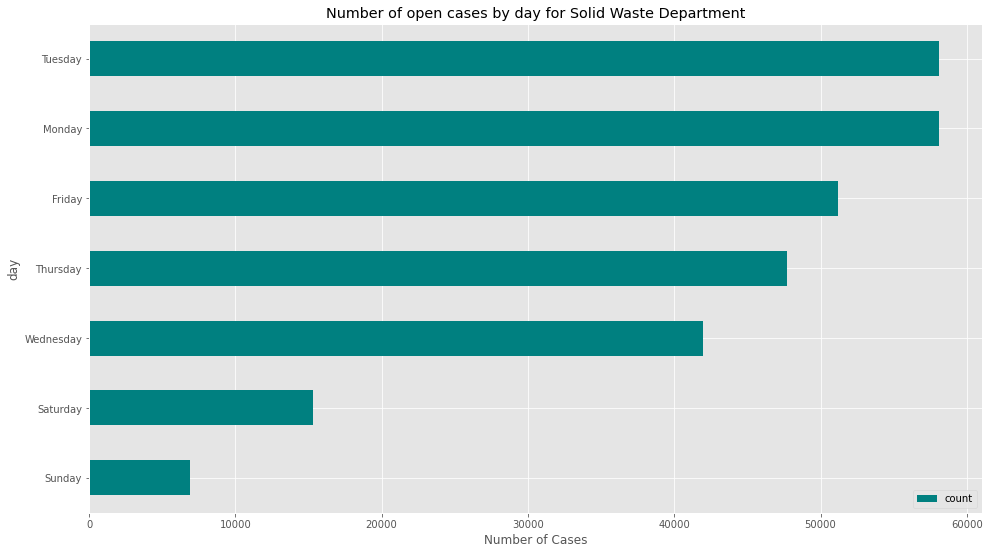

In [273]:
df_pandas.groupby('day').sum().sort_values(by = 'count').plot.barh(figsize=(16,9), color = "teal")
plt.title("Number of open cases by day for Solid Waste Department")
plt.xlabel("Number of Cases")
plt.show()